In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn


''''
Goal is given a player and some of his stats from the last couple games and some stats on the opponent to output a prediction on the amount of points he will score in a game.
Glossary:

Rk -- Rank
Gcar -- Career Game Number for Player
Click to see career stats through the
end of this game for this player.
Gtm -- Season Game Number for Team
Click to see season stats through the
end of this game for this player.
GS -- Games Started
MP -- Minutes Played
FG -- Field Goals
FGA -- Field Goal Attempts
FG% -- Field Goal Percentage
3P -- 3-Point Field Goals
3PA -- 3-Point Field Goal Attempts
3P% -- 3-Point Field Goal Percentage
2P -- 2-Point Field Goals
2PA -- 2-Point Field Goal Attempts
2P% -- 2-Point Field Goal Percentage
eFG% -- Effective Field Goal Percentage
This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
FT -- Free Throws
FTA -- Free Throw Attempts
FT% -- Free Throw Percentage
ORB -- Offensive Rebounds
DRB -- Defensive Rebounds
TRB -- Total Rebounds
AST -- Assists
STL -- Steals
BLK -- Blocks
TOV -- Turnovers
PF -- Personal Fouls
PTS -- Points
GmSc -- Game Score
+/- -- Plus-Minus


Feature set: 
1) Player recent form (rolling windows)

last5_pts_avg

last5_min_avg, last5_fga_avg, last5_3pa_avg, last5_fta_avg

last1_min (workload last game)

Shooting efficiency proxies: last5_fg_pct, last5_ts_pct (if you have FTA/FGA/3PA)

Stability: last5_pts_std (variance in role/performance)

2) Workload & rest

days_rest (since previous game)

is_b2b (back-to-back), games_past_7d

3) Opponent team defense & pace (season-to-date or last-N games)

opp_def_rating (points allowed per 100 possessions). 
NBA
+1

Opponent Four Factors (defense): opp_def_efg, opp_def_tov_pct, opp_def_drb_pct, opp_def_ft_fga. 
NBA
+1

opp_pace (possessions per 48). 
Basketball Reference

4) Context

home (1=home, 0=away)

month_sin, month_cos (seasonality)

team_pace_sd (your team’s pace season-to-date)



'''

"'\nGoal is given a player and some of his stats from the last couple games and some stats on the opponent to output a prediction on the amount of points he will score in a game.\nGlossary:\n\nRk -- Rank\nGcar -- Career Game Number for Player\nClick to see career stats through the\nend of this game for this player.\nGtm -- Season Game Number for Team\nClick to see season stats through the\nend of this game for this player.\nGS -- Games Started\nMP -- Minutes Played\nFG -- Field Goals\nFGA -- Field Goal Attempts\nFG% -- Field Goal Percentage\n3P -- 3-Point Field Goals\n3PA -- 3-Point Field Goal Attempts\n3P% -- 3-Point Field Goal Percentage\n2P -- 2-Point Field Goals\n2PA -- 2-Point Field Goal Attempts\n2P% -- 2-Point Field Goal Percentage\neFG% -- Effective Field Goal Percentage\nThis statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.\nFT -- Free Throws\nFTA -- Free Throw Attempts\nFT% -- Free Throw Percentage\nORB -- Offensive R

## Data wrangling, feature engineering

In [479]:
def get_feature_and_output_from_csv(player_csv, all_teams_csv):
    # Read csv and convert relevant columns to numbers
    numeric_cols = ["Rk","Gcar","Gtm","FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","eFG%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS","GmSc","+/-"]
    player_df = pd.read_csv(player_csv, converters={c: (lambda x: pd.to_numeric(x, errors="ignore")) for c in numeric_cols})
    

    # Derive boolean column of home/away
    player_df.rename(columns={"Unnamed: 5": "Home Game"}, inplace=True)
    player_df["Home Game"] = player_df["Home Game"] != "@"

    # Drop inactive games
    player_df = player_df.dropna(subset=["Gcar"])
    # print(player_df.head(40))

    
    # Convert string time stamp to number for minutes played
    def mmss_to_minutes(x):
        if pd.isna(x):
            return np.nan
        try:
            m, s = str(x).split(":")
            return int(m) + int(s) / 60.0
        except Exception:
            return np.nan

    player_df["MP_min"] = player_df["MP"].apply(mmss_to_minutes)

    # Conver date of game to datetime object
    player_df["Date"] = pd.to_datetime(player_df["Date"], errors="coerce")

    player_df["last5_pts_avg"] = player_df["PTS"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last5_min_avg"] = player_df["MP_min"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last5_fga_avg"] = player_df["FGA"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last5_3pa_avg"] = player_df["3PA"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last5_fta_avg"] = player_df["FTA"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last5_efg_avg"] = player_df["eFG%"].shift(1).rolling(5, min_periods=5).mean()
    player_df["last1_min_played"] = player_df["MP_min"].shift(1)
    player_df["days_rest"] = (player_df["Date"] - player_df["Date"].shift(1)).dt.days


    # All team stats to get opposing team defensive stats
    team_defense_stats = pd.read_csv(all_teams_csv)
    # Drop league average row
    team_defense_stats.drop(30, inplace=True)

    NAME_TO_ABBR = {
        "Atlanta Hawks": "ATL",
        "Boston Celtics": "BOS",
        "Brooklyn Nets": "BRK",   # B-Ref uses BRK (not BKN)
        "Charlotte Hornets": "CHO",# B-Ref uses CHO (not CHA)
        "Chicago Bulls": "CHI",
        "Cleveland Cavaliers": "CLE",
        "Dallas Mavericks": "DAL",
        "Denver Nuggets": "DEN",
        "Detroit Pistons": "DET",
        "Golden State Warriors": "GSW",
        "Houston Rockets": "HOU",
        "Indiana Pacers": "IND",
        "Los Angeles Clippers": "LAC",
        "Los Angeles Lakers": "LAL",
        "Memphis Grizzlies": "MEM",
        "Miami Heat": "MIA",
        "Milwaukee Bucks": "MIL",
        "Minnesota Timberwolves": "MIN",
        "New Orleans Pelicans": "NOP",
        "New York Knicks": "NYK",
        "Oklahoma City Thunder": "OKC",
        "Orlando Magic": "ORL",
        "Philadelphia 76ers": "PHI",
        "Phoenix Suns": "PHO",    # B-Ref uses PHO (not PHX)
        "Portland Trail Blazers": "POR",
        "Sacramento Kings": "SAC",
        "San Antonio Spurs": "SAS",
        "Toronto Raptors": "TOR",
        "Utah Jazz": "UTA",
        "Washington Wizards": "WAS",
    }

    # Strip asterisk and map on abbreviation
    team_defense_stats["Team"] = team_defense_stats["Team"].str.replace("*", "", regex=False).str.strip()
    team_defense_stats["Team_abbr"] = team_defense_stats["Team"].map(NAME_TO_ABBR)
    team_defense_stats.set_index("Team_abbr", inplace=True)

    cols = ["DRtg","Pace","eFG%","TOV%","DRB%","FT/FGA"]  # pick what you need
    player_df = player_df.join(
        team_defense_stats[cols].add_prefix("opp_"),  # avoid name collisions
        on="Opp"                          # join key is giannis_df['Opp'] vs def_df.index
    )

    player_df["Home Game"] = player_df["Home Game"].astype(int)

    # List of the exact columns you want in your feature set
    feature_cols = [
        "last5_pts_avg",
        "last5_min_avg",
        "last5_fga_avg",
        "last5_3pa_avg",
        "last5_fta_avg",
        "last5_efg_avg",
        "last1_min_played",
        "days_rest",
        "opp_DRtg",
        "opp_Pace",
        "opp_eFG%",
        "opp_TOV%",
        "opp_DRB%",
        "opp_FT/FGA",
        "Home Game"
    ]

    return player_df[feature_cols][5:].copy(), player_df["PTS"][5:].copy()

In [496]:
feature_df, y = get_feature_and_output_from_csv("data/giannis_2025.csv", "data/team-stats-2025.csv")

C:\Users\Jon\AppData\Local\Temp\ipykernel_18052\488982248.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  player_df = pd.read_csv(player_csv, converters={c: (lambda x: pd.to_numeric(x, errors="ignore")) for c in numeric_cols})


In [511]:
def compute_model_output(x, w, b):
    return np.dot(x, w) + b

In [ ]:
features_to_plot = feature_df.columns

for feature in features_to_plot:
    plt.figure()
    plt.scatter(giannis_feature_set_df[feature], giannis_pts_y_set, alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel("Actual Points This Game")
    plt.title(f"Giannis: {feature} vs Actual Points")
    plt.show()

In [573]:
def compute_cost(x, y_target, w, b):
    lambda_ = 10
    y_pred = compute_model_output(x, w, b)
    squared_diff = (y_pred - y_target) ** 2
    return (np.mean(squared_diff) / 2) + (lambda_ / (2 * len(x))) * np.sum(w ** 2)

In [574]:
def compute_gradient(x, y_target, w, b):
    lambda_ = 10
    dj_dw = (np.dot((compute_model_output(x, w, b) - y_target), x) / len(x)) + (lambda_ / len(x) * w)
    dj_db = np.sum((compute_model_output(x, w, b) - y_target)) / len(x)
    # print(f"dj_dw: {dj_dw} dj_db: {dj_db}")
    return (dj_dw, dj_db)

In [575]:
def compute_gradient_descent(x, y_target, alpha, iterations):
    w = np.zeros(shape=x.shape[1])
    b = 0
    cost_history = []
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient(x, y_target, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost_history.append(compute_cost(x, y_target, w, b))
    print(f"dw = {dj_dw} db = {dj_db}")
    # print(f"cost = {compute_cost(x, y_target, w, b)}")
    # Graph the learning curve
    plt.plot(np.arange(iterations), cost_history)
    plt.xlabel('Iterations')
    plt.ylabel('J(w,b)')
    plt.title('Learning Curve')
    plt.show()
    return w, b

In [487]:
def get_scaled_matrix(X):
    mean_x = np.mean(X, axis=0)
    std_x = np.std(X, axis=0)
    scaled_X = (X - mean_x) / std_x
    return scaled_X

dw = [np.float64(0.047962972768920885) np.float64(-0.011758446873123274)
 np.float64(-0.02875506309893761) np.float64(-0.013432360788487904)
 np.float64(-0.04022577881511541) np.float64(-0.005549607668833216)
 np.float64(0.013305941946137212) np.float64(0.005396840111970863)
 np.float64(-0.0030006693337981324) np.float64(0.007595171144326576)
 np.float64(0.010346865464507873) np.float64(0.027625846249324904)
 np.float64(-0.01204712350029788) np.float64(-0.020353475344939143)
 np.float64(-0.007565416697732336)] db = -0.1893765203923535


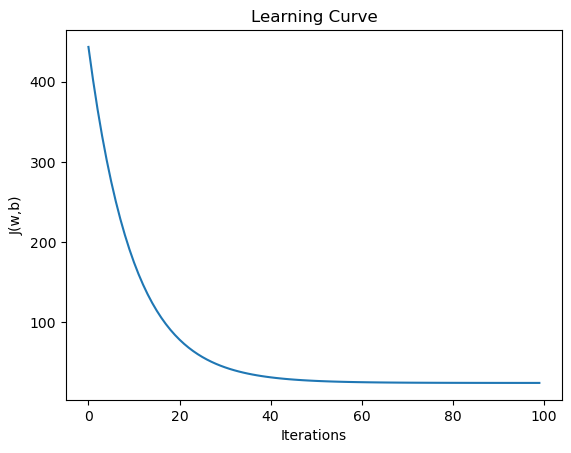

In [576]:
w_scaled, b_scaled = compute_gradient_descent(get_scaled_matrix(feature_df.to_numpy()), y_df.to_numpy(), 0.05, 100)

In [588]:
feature_df_2024, y_df_2024 = get_feature_and_output_from_csv("data/giannis_2024.csv", "data/team-stats-2024.csv")

C:\Users\Jon\AppData\Local\Temp\ipykernel_18052\488982248.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  player_df = pd.read_csv(player_csv, converters={c: (lambda x: pd.to_numeric(x, errors="ignore")) for c in numeric_cols})


In [589]:
cost = compute_cost(get_scaled_matrix(feature_df_2024.to_numpy()), y_df_2024.to_numpy(), w_scaled, b_scaled)

In [590]:
cost

np.float64(51.92665746588333)

In [591]:
np.sqrt(cost * 2)

np.float64(10.190844662331315)

In [592]:
y_df_2024.to_numpy().std()

np.float64(9.0841414727853)

In [593]:
compute_model_output(get_scaled_matrix(feature_df_2024.to_numpy())[0, :], w_scaled, b_scaled)

np.float64(28.86971879324153)

In [512]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [514]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(feature_df.to_numpy())

In [515]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_norm, y.to_numpy())

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,None


In [517]:
sk_w_norm, sk_b_norm = sgdr.coef_, sgdr.intercept_
print(f"sk_w: {sk_w_norm} sk_b: {sk_b_norm}")
print(f"my_w: {w_scaled} my__b: {b_scaled}")

sk_w: [-1.80219645  0.88498723  1.22626848  0.32010481  2.20916663  0.07305786
 -0.9432206  -0.80617291  0.32525057 -0.28233222  0.11349594 -1.1432305
  1.14893434  0.79645946  1.27590434] sk_b: [30.3883031]
my_w: [np.float64(-0.3506330140047835) np.float64(0.8799040982025408)
 np.float64(0.12352787541449659) np.float64(0.07564368260673335)
 np.float64(1.2670050789445608) np.float64(-0.29814441281528203)
 np.float64(-0.8988463108308923) np.float64(-0.7464311333516767)
 np.float64(0.38867765141053456) np.float64(-0.28401919933697517)
 np.float64(0.1748519818975865) np.float64(-0.8948599406801017)
 np.float64(1.1075682202935653) np.float64(0.6626566740265779)
 np.float64(1.2590917006109894)] my__b: 30.20718907982084


In [518]:
np.sqrt(compute_cost(get_scaled_matrix(feature_df_2024.to_numpy()), y_df_2024.to_numpy(), sk_w_norm, sk_b_norm) * 2)

np.float64(10.763503379535203)

In [520]:
feature_df.head()

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last5_efg_avg,last1_min_played,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
5,30.4,34.450000,18.6,0.6,11.4,0.6652,33.516667,2.0,112.2,99.8,0.528,12.6,74.8,0.181,1
7,32.2,35.983333,21.8,0.6,9.6,0.6310,38.866667,5.0,120.4,100.0,0.559,10.3,74.1,0.185,1
8,30.8,34.996667,21.4,0.4,8.8,0.6054,30.200000,1.0,114.3,96.7,0.549,13.1,74.5,0.176,0
9,31.2,34.773333,23.4,0.6,7.8,0.5830,32.200000,2.0,111.1,95.7,0.522,11.6,76.0,0.154,1
10,33.8,34.786667,24.0,0.6,8.6,0.6030,39.150000,2.0,114.8,99.7,0.541,13.2,73.9,0.222,1


In [594]:
# New data
np.sqrt(compute_cost(get_scaled_matrix(feature_df_2024.to_numpy()), y_df_2024.to_numpy(), w_scaled, b_scaled) * 2)

np.float64(10.190844662331315)

In [595]:
# Cost on original training data is lower than cost on new data, overfitting has occured
np.sqrt(compute_cost(get_scaled_matrix(feature_df.to_numpy()), y.to_numpy(), w_scaled, b_scaled) * 2)

np.float64(7.0044508206276195)

dw = [np.float64(0.05430865453345934) np.float64(-0.016777292469440874)
 np.float64(-0.031664095258322866) np.float64(-0.04067266723761925)
 np.float64(0.015159307506272063) np.float64(0.004851833629768529)
 np.float64(-0.06032010255130714) np.float64(0.006069992585902545)
 np.float64(0.04571905953645373) np.float64(-0.0279937531714243)
 np.float64(-0.0021033641709275255) np.float64(-0.007555131874891208)] db = -0.1893765203923526


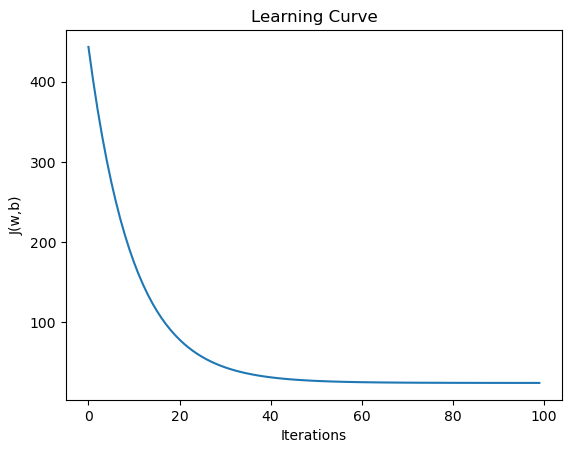

In [601]:
# Reduce features to attempt to reduce overfiting
reduced_feature_df = feature_df.drop(["last5_3pa_avg", "last5_efg_avg", "opp_TOV%"], axis=1)
reduced_w_norm, reduced_b_norm = compute_gradient_descent(get_scaled_matrix(reduced_feature_df.to_numpy()), y_df.to_numpy(), 0.05, 100)

We slightly reduced our cost here, maybe we're on the right track

In [602]:
np.sqrt(compute_cost(get_scaled_matrix(feature_df_2024.drop(["last5_3pa_avg", "last5_efg_avg", "opp_TOV%"], axis=1).to_numpy()), y_df_2024.to_numpy(), reduced_w_norm, reduced_b_norm) * 2)

np.float64(10.041508086278846)

dw = [np.float64(0.06063001135026572) np.float64(-0.025526712878905733)
 np.float64(-0.031143306673646648) np.float64(-0.04290798046311764)
 np.float64(0.022208562803746668) np.float64(0.0028157498753795945)
 np.float64(-0.007082229970575702) np.float64(-0.0014028550564616875)
 np.float64(0.013984187710391074) np.float64(-0.007736296082121452)] db = -0.18937652039234973


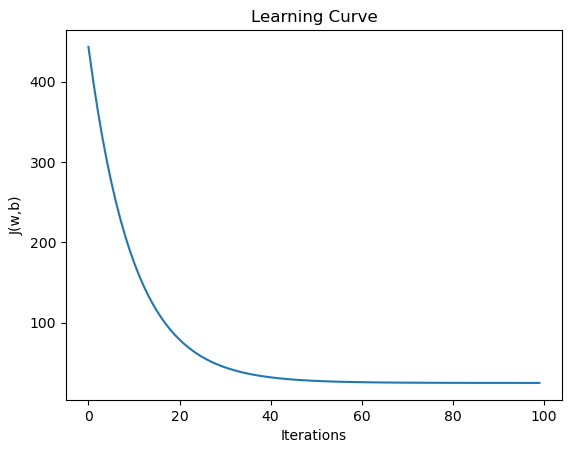

In [603]:
reduced_feature_df = feature_df.drop(["last5_3pa_avg", "last5_efg_avg", "opp_TOV%", "opp_DRB%", "opp_FT/FGA"], axis=1)
reduced_w_norm, reduced_b_norm = compute_gradient_descent(get_scaled_matrix(reduced_feature_df.to_numpy()), y_df.to_numpy(), 0.05, 100)

In [604]:
np.sqrt(compute_cost(get_scaled_matrix(feature_df_2024.drop(["last5_3pa_avg", "last5_efg_avg", "opp_TOV%", "opp_DRB%", "opp_FT/FGA"], axis=1).to_numpy()), y_df_2024.to_numpy(), reduced_w_norm, reduced_b_norm) * 2)

np.float64(9.943953770665996)